<a href="https://colab.research.google.com/github/BellalZY/Alzheimer-classification-desnet201/blob/main/alzheimer_s_classification_densenet201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os
import tqdm
import glob
import tensorflow

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import gray2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.preprocessing.image import load_img, img_to_array

### IMPORT / VIEWING / PREPROCESSING DATASET

> `DATA AUGMENTATION`

In [2]:
# train_datagen = ImageDataGenerator(rescale = 1./255,
#                                    rotation_range=30,
#                                    zoom_range=0.2,
#                                    horizontal_flip=True,
#                                    vertical_flip=True,
#                                    validation_split = 0.2)

# valid_datagen = ImageDataGenerator(rescale = 1./255,
#                                    validation_split = 0.2)

# test_datagen  = ImageDataGenerator(rescale = 1./255)

In [2]:
!unzip archive.zip -d input

Streaming output truncated to the last 5000 lines.
  inflating: input/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (46).jpg  
  inflating: input/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (47).jpg  
  inflating: input/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (48).jpg  
  inflating: input/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (49).jpg  
  inflating: input/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (5).jpg  
  inflating: input/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (50).jpg  
  inflating: input/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (51).jpg  
  inflating: input/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (52).jpg  
  inflating: input/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (53).jpg  
  inflating: input/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (54).jpg  
  inflating: input/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (55).jpg  
  inflating: input/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (56).jpg  
  inflating: input/Alzheim

In [3]:

import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the root folder of your dataset
dataset_path = "/content/input/Alzheimer_MRI_4_classes_dataset"

# Define paths for train, validation, and test splits
output_base = "./split_data"  # Base folder to store split data
train_dir = os.path.join(output_base, "train")
val_dir = os.path.join(output_base, "val")
test_dir = os.path.join(output_base, "test")

# Create train, validation, and test directories
for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

# Split and Organize Dataset
def split_dataset(input_dir, output_dirs, test_size=0.2, val_size=0.2):
    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_path):  # Skip non-folder items
            continue

        # Get all file names for the current class
        images = os.listdir(class_path)
        train_imgs, test_imgs = train_test_split(images, test_size=test_size, random_state=42)
        train_imgs, val_imgs = train_test_split(train_imgs, test_size=val_size/(1-test_size), random_state=42)

        # Copy images to corresponding split folders
        for split_name, img_list in zip(["train", "val", "test"], [train_imgs, val_imgs, test_imgs]):
            split_path = os.path.join(output_dirs[split_name], class_name)
            os.makedirs(split_path, exist_ok=True)
            for img in img_list:
                src_path = os.path.join(class_path, img)
                dest_path = os.path.join(split_path, img)
                shutil.copy(src_path, dest_path)

# Run the split
output_dirs = {"train": train_dir, "val": val_dir, "test": test_dir}
split_dataset(dataset_path, output_dirs, test_size=0.2, val_size=0.1)

# Confirm the split
print("Data successfully split into train, val, and test directories.")

# ImageDataGenerator for Training, Validation, and Test
train_datagen = ImageDataGenerator(rescale=1.0/255)
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Train Dataset
train_dataset = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical'
)

# Validation Dataset
valid_dataset = val_test_datagen.flow_from_directory(
    val_dir, target_size=(224, 224), batch_size=32, class_mode='categorical'
)

# Test Dataset
test_dataset = val_test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False
)

Data successfully split into train, val, and test directories.
Found 4478 images belonging to 4 classes.
Found 641 images belonging to 4 classes.
Found 1281 images belonging to 4 classes.


100%|██████████| 5/5 [00:00<00:00, 22.38it/s]


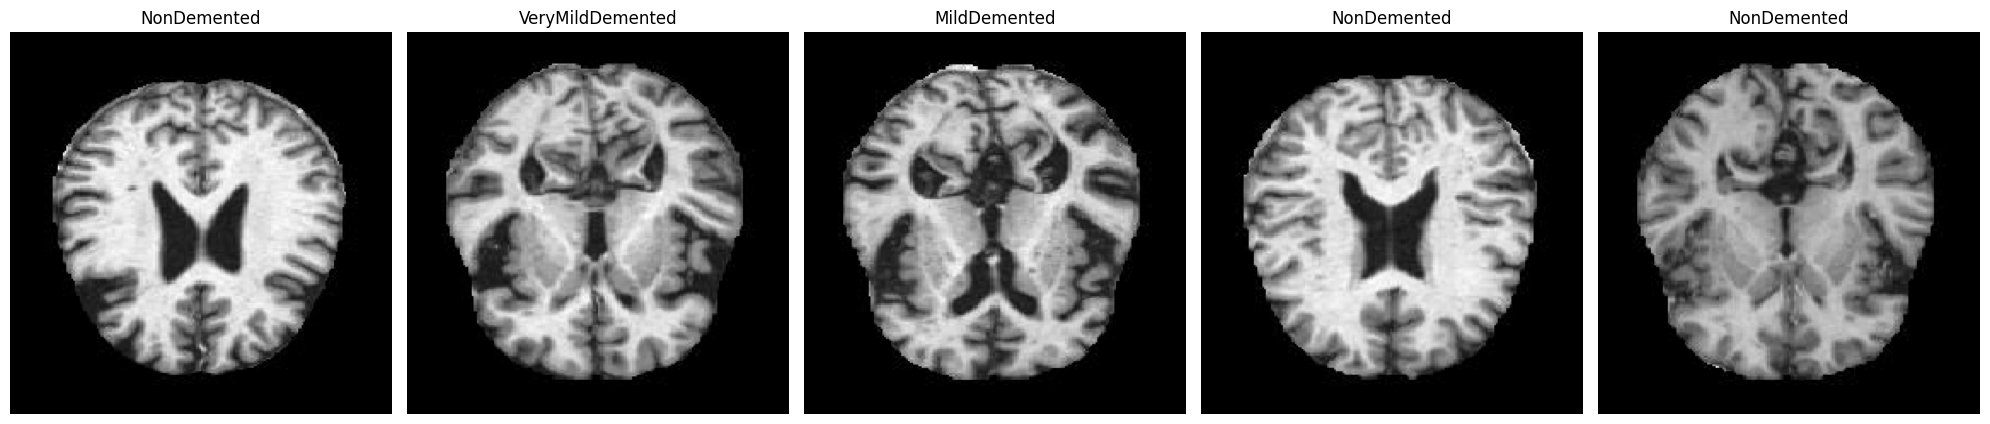

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Class names based on the generator
class_names = list(train_dataset.class_indices.keys())

# Create a plot with 5 random images
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))

for i in tqdm(range(0, 5)):
    # Randomly select a batch and image index
    batch = next(train_dataset)  # Fetch the next batch
    images, labels = batch  # Unpack images and labels from the batch
    rand_idx = np.random.randint(0, len(images))  # Random index in the batch

    # Get the random image and label
    img = images[rand_idx]
    label = labels[rand_idx]
    label_idx = np.argmax(label)  # Convert one-hot encoding to class index

    # Plot the image
    ax[i].imshow(img)  # Images are already normalized by ImageDataGenerator
    ax[i].axis('off')
    ax[i].set_title(class_names[label_idx])  # Display the class name

plt.tight_layout()
plt.show()

### MODEL BUILDING

In [5]:
# Model Initialization

base_model = DenseNet201(input_shape=(224,224,3),
                         include_top=False,
                         weights="imagenet")

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [7]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [8]:
# Summary

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)             │ (None, 7, 7, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 7, 1920)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 94080)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 94080)               │         376,320 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │     192,677,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │           4,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 213,490,756 (814.40 MB)

 Trainable params: 194,974,468 (743.77 MB)

 Non-trainable params: 18,516,288 (70.63 MB)

In [9]:
# Model Compile

OPT    = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [10]:
# Defining Callbacks

filepath = './best_weights.keras'

earlystopping = EarlyStopping(monitor = 'val_auc',
                              mode = 'max' ,
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath,
                                monitor = 'val_auc',
                                mode='max',
                                save_best_only=True,
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [11]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 20,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - auc: 0.8136 - loss: 1.2600
Epoch 1: val_auc improved from -inf to 0.94644, saving model to ./best_weights.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 162s 800ms/step - auc: 0.8140 - loss: 1.2582 - val_auc: 0.9464 - val_loss: 0.5522
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - auc: 0.9606 - loss: 0.4736
Epoch 2: val_auc improved from 0.94644 to 0.97720, saving model to ./best_weights.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 72s 509ms/step - auc: 0.9606 - loss: 0.4735 - val_auc: 0.9772 - val_loss: 0.3527
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - auc: 0.9850 - loss: 0.2749
Epoch 3: val_auc improved from 0.97720 to 0.98153, saving model to ./best_weights.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 49s 345ms/step - auc: 0.9850 - loss: 0.2749 - val_auc: 0.9815 - val_loss: 0.3182
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - auc: 0.9883 - loss: 0.2384
Epoch 4: val_auc improved from 0.98153 to 0.98649, saving model to ./best_weights.keras

### MODEL EVALUATION

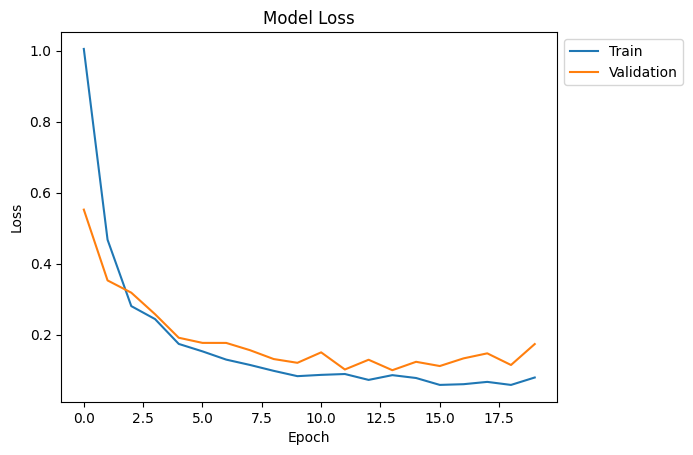

In [12]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

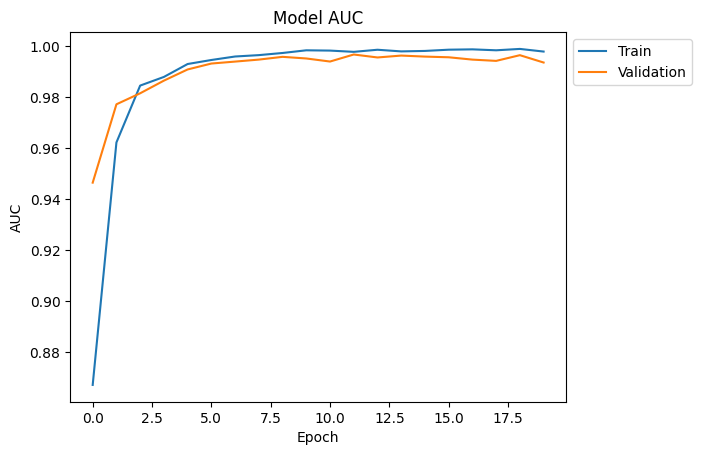

In [13]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
# Test Data

# test_dataset  = test_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test',
#                                                  target_size = (224,224),
#                                                  class_mode = 'categorical',
                                                #  batch_size = 128)

Found 1279 images belonging to 4 classes.


In [14]:
# Evaluating Loss and AUC

model.evaluate(test_dataset)

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - auc: 0.9947 - loss: 0.1642


[0.1683039367198944, 0.994528591632843]

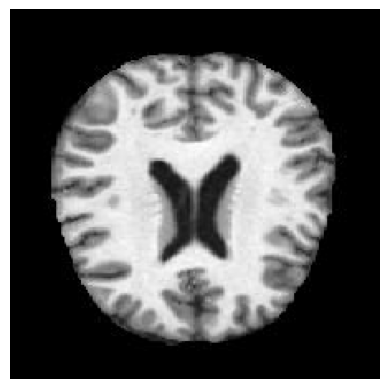

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
100.0% chances are there that the image is NonDemented


In [18]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Mapping indices back to class names
dic = test_dataset.class_indices
idc = {v: k for k, v in dic.items()}

# Load and preprocess the image
img = load_img(test_dir + '/NonDemented/26 (34).jpg', target_size=(224, 224))
img = img_to_array(img)
img = img / 255.0  # Normalize the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Expand dimensions to match the model's expected input shape
img = np.expand_dims(img, axis=0)

# Get the prediction
predictions = model.predict(img)  # Returns probabilities for each class
predicted_class = np.argmax(predictions[0])  # Class with the highest probability
probability = round(np.max(predictions[0]) * 100, 2)  # Highest probability in percentage

# Print the result
print(f"{probability}% chances are there that the image is {idc[predicted_class]}")

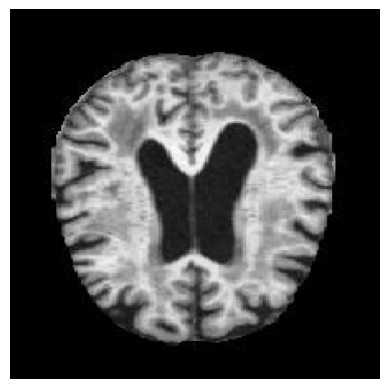

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
100.0% chances are there that the image is MildDemented


In [21]:
# Load and preprocess the image
img = load_img(test_dir + '/MildDemented/26 (24).jpg', target_size=(224, 224))
img = img_to_array(img)
img = img / 255.0  # Normalize the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Expand dimensions to match the model's expected input shape
img = np.expand_dims(img, axis=0)

# Get the prediction
predictions = model.predict(img)  # Returns probabilities for each class
predicted_class = np.argmax(predictions[0])  # Class with the highest probability
probability = round(np.max(predictions[0]) * 100, 2)  # Highest probability in percentage

# Print the result
print(f"{probability}% chances are there that the image is {idc[predicted_class]}")

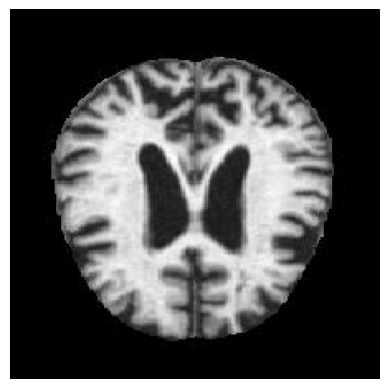

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
90.34% chances are there that the image is ModerateDemented


In [23]:
# Load and preprocess the image
img = load_img(test_dir + '/ModerateDemented/32 (2).jpg', target_size=(224, 224))
img = img_to_array(img)
img = img / 255.0  # Normalize the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Expand dimensions to match the model's expected input shape
img = np.expand_dims(img, axis=0)

# Get the prediction
predictions = model.predict(img)  # Returns probabilities for each class
predicted_class = np.argmax(predictions[0])  # Class with the highest probability
probability = round(np.max(predictions[0]) * 100, 2)  # Highest probability in percentage

# Print the result
print(f"{probability}% chances are there that the image is {idc[predicted_class]}")

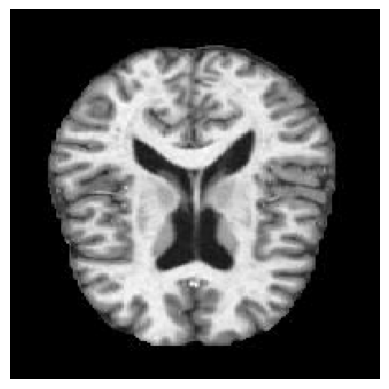

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
99.85% chances are there that the image is VeryMildDemented


In [25]:
# Load and preprocess the image
img = load_img(test_dir + '/VeryMildDemented/16 (31).jpg', target_size=(224, 224))
img = img_to_array(img)
img = img / 255.0  # Normalize the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Expand dimensions to match the model's expected input shape
img = np.expand_dims(img, axis=0)

# Get the prediction
predictions = model.predict(img)  # Returns probabilities for each class
predicted_class = np.argmax(predictions[0])  # Class with the highest probability
probability = round(np.max(predictions[0]) * 100, 2)  # Highest probability in percentage

# Print the result
print(f"{probability}% chances are there that the image is {idc[predicted_class]}")

Conclusion:

So, we have finally built are deep learning model using DenseNet162 transfer learning algorithm and acheived and AUC-90%.